# Peak Model Visualisations

In [1]:
import altair as alt
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates



import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt

import datetime 

alt.data_transformers.disable_max_rows()

%matplotlib inline

# Parameters

In [2]:
peak_model_dataset = '../data/processed/peak_models_for_countries.csv'

# The Dataset

In [3]:
df = pd.read_csv(peak_model_dataset, parse_dates=['date'])
df.shape

(28450, 96)

In [4]:
df['country'].nunique()

207

# Combination Model

## Visualising a Single Country/Region

In [5]:
def plot_growth(ax, data, peak_label='cases/day', **kwargs):

    peak_date, peak_value = data.idxmax(), data.max()
    
    current_week, prev_week = data[-7:].sum(), data[-14:-7].sum()
    
    rel = data/peak_value
    
    # Plot the growth line
    ax.plot(rel.index, rel, lw=2, c='k')
    ax.fill_between(rel.index, 0, rel, color='whitesmoke')
    
    # Highlight and label the end point
    end_date, end_value = rel.index[-1], rel[-1]
    
    end_pct = int(100*end_value)
    end_text = '<1%' if end_pct<1 else '  {}%'.format(end_pct)
    end_text = end_text+'↑' if current_week>prev_week else end_text+'↓'
    
    ax.plot(end_date, end_value, marker='o', markersize=3, c='k')
    
    end_value_y_adj = -.05 if end_value>0.1 else 0.05
    ax.text(end_date, end_value+end_value_y_adj, '{}'.format(end_text), color='dimgrey', ha='left', **kwargs)

    # Highlight and label the peak
    ax.plot(peak_date, 1, marker='o', markersize=6, c='r')
    ax.plot(peak_date, 1, marker='o', markersize=1, c='k')
    
    if peak_value < 1:
        peak_value_text = '<1'
    else:
        peak_value_text = '~{:,}k'.format(round(peak_value/1000, 1)) if peak_value>999 else '~{:,}'.format(int(peak_value))

    ha = 'left' if peak_date<datetime.datetime.strptime('01/05/2020', "%d/%m/%Y") else 'right'
    ax.text(peak_date, 1.075, ' {}\n {}'.format(peak_value_text, peak_label), color='dimgrey', ha=ha, **kwargs)

        

    return rel

In [67]:
def plot_lockdown(ax, lockdown, h=.25, bottom=0, title='', **kwargs):
    
    # The colour map
    transition_colours = ['white', 'skyblue', 'yellow', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)

    # Current and last week's values
    current_week, prev_week = lockdown[-7:].sum(), lockdown[-14:-7].sum()

    # Normalise lockdown & assign colours
    rel = lockdown/100
    colours = [cmap(v) for v in rel.values]


    # Plot the bars
    ax.bar(rel.index, [h]*len(rel.index), bottom=bottom, width=2, color=colours)
    
    # Plot the trace
    ax.plot(rel.index, (rel*h)+bottom, lw=1, c='dimgrey')
    
    # Label the current status
    label_x = ax.get_xlim()[1]
    label_y = (rel[-1]*h)+bottom
    label = int(rel[-1]*100)
    arrow = '↑' if current_week>prev_week else '↓'
        
    ax.annotate('{:,}%{}'.format(label, arrow), xy=(label_x, label_y-.05), color='dimgrey', **kwargs)
    ax.plot(rel.index[-1], label_y, marker='o', markersize=3, c='k')
    
    # Label the lockdown chart
    ax.text(ax.get_xlim()[0], bottom+.1, '{} ({:,}%/d)'.format(title, int(lockdown.mean())), color='dimgrey', **kwargs)


    

In [68]:
def plot_stages(ax, growth_data, stages, **kwargs):
    
    peak_value = growth_data.max()
    
    # Add the growth stages
    stage_start_dates = stages.reset_index().groupby(
        stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()

    stage_start_dates['date'].map(
        lambda start_date: ax.plot([start_date]*2, [0, growth_data[start_date]/peak_value], lw=.25, c='k'))

In [69]:
def plot_annotations(ax, title, total_cases, total_deaths, **kwargs):
    
    # The title
    ax.set_title('{}\n{:,} cases/M, {:,} deaths/M\nCFR ~ {}'.format(
        title, 
        int(total_cases), 
        int(total_deaths),
        round(total_deaths/total_cases, 3)
    ), loc='left', fontsize=int(kwargs['fontsize']*1))
    
    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    # Remove the axes spines and the y ticks
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    [t.set_visible(False) for t in ax.get_yticklabels()]

    ax.spines['bottom'].set_visible(True)


    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[:3]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        
    ax.tick_params(axis = 'x', which = 'major', width=1, length=5, labelsize=kwargs['fontsize'], labelcolor='dimgrey', color='dimgrey')


In [70]:
def plot_peak_lockdown_model(
    ax, df, 
    growth_col='new_cases_rolling_mean', 
    mobility_col='google_rolling_mobility_drop', 
    stringency_col='stringency_index', 
    **kwargs
):
    start_date, end_date = datetime.date(2020, 1, 1), datetime.datetime.today()
    
    ax.set_xlim(start_date, end_date)
    
    
    total_cases_per_million = df['total_cases_per_million'].max()
    total_deaths_per_million = df['total_deaths_per_million'].max()

    
    stage_col = growth_col+'_stage'

    growth_data = df[growth_col].ffill()
    
    mobility_data = df[mobility_col].ffill()
    stringency_data = df[stringency_col].ffill()
    
    stage_data = df[stage_col].ffill()
    
    plot_growth(ax, growth_data, **kwargs)
    plot_stages(ax, growth_data, stage_data, **kwargs)

    bx = ax.twinx()
    if stringency_data.notnull().any(): plot_lockdown(bx, stringency_data, bottom=.33, h=.3, title='SI', **kwargs)
    if mobility_data.notnull().any(): plot_lockdown(bx, mobility_data, bottom=0, h=.3, title='MD', **kwargs)
    
    
    ax.set_ylim(-.6, 1.4)
    bx.set_ylim(0, 2.2)

    bx.axis('off')
    
    pop = int(df.iloc[0]['population']//1000000)
    med_age = int(df.iloc[0]['median_age'])
    country_title = '{} (p.{}M, age~{})'.format(df.iloc[0]['country'], '<1' if pop <1 else '~'+str(pop), med_age)

    plot_annotations(ax, country_title, total_cases_per_million, total_deaths_per_million, **kwargs)
    
    return
    
    
    

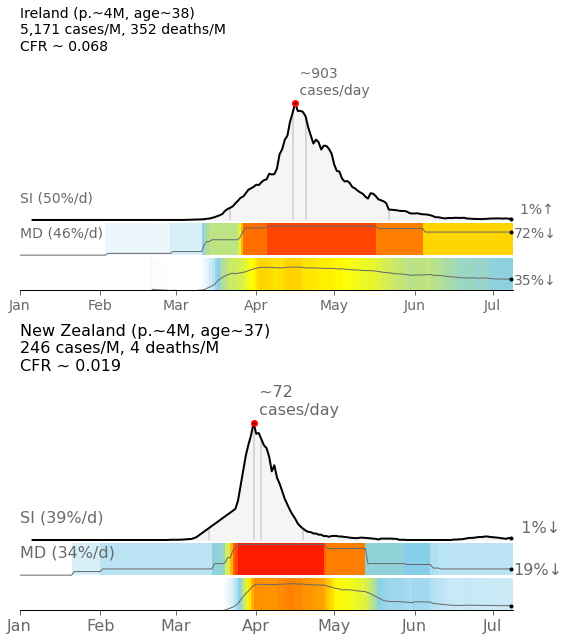

In [71]:
sns.set_context('paper')

fig, (ax, bx) = plt.subplots(figsize=(8, 9), nrows=2)

country = 'Ireland'

data = df[df['country']==country].set_index('date')

plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=14)


country = 'New Zealand'

data = df[df['country']==country].set_index('date')

plot_peak_lockdown_model(bx, data, growth_col='new_cases_rolling_mean', fontsize=16)

fig.tight_layout()

# Europe

In [72]:
min_pop = 500000
europe = df[(df['population']>min_pop) & (df['continent']=='Europe')]

total_cases_per_capita = europe.groupby('country')['total_cases_per_million'].max()

sorted_european_countries = sorted(europe.country.unique(), key=lambda c: total_cases_per_capita[c], reverse=True)
len(sorted_european_countries)

37

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


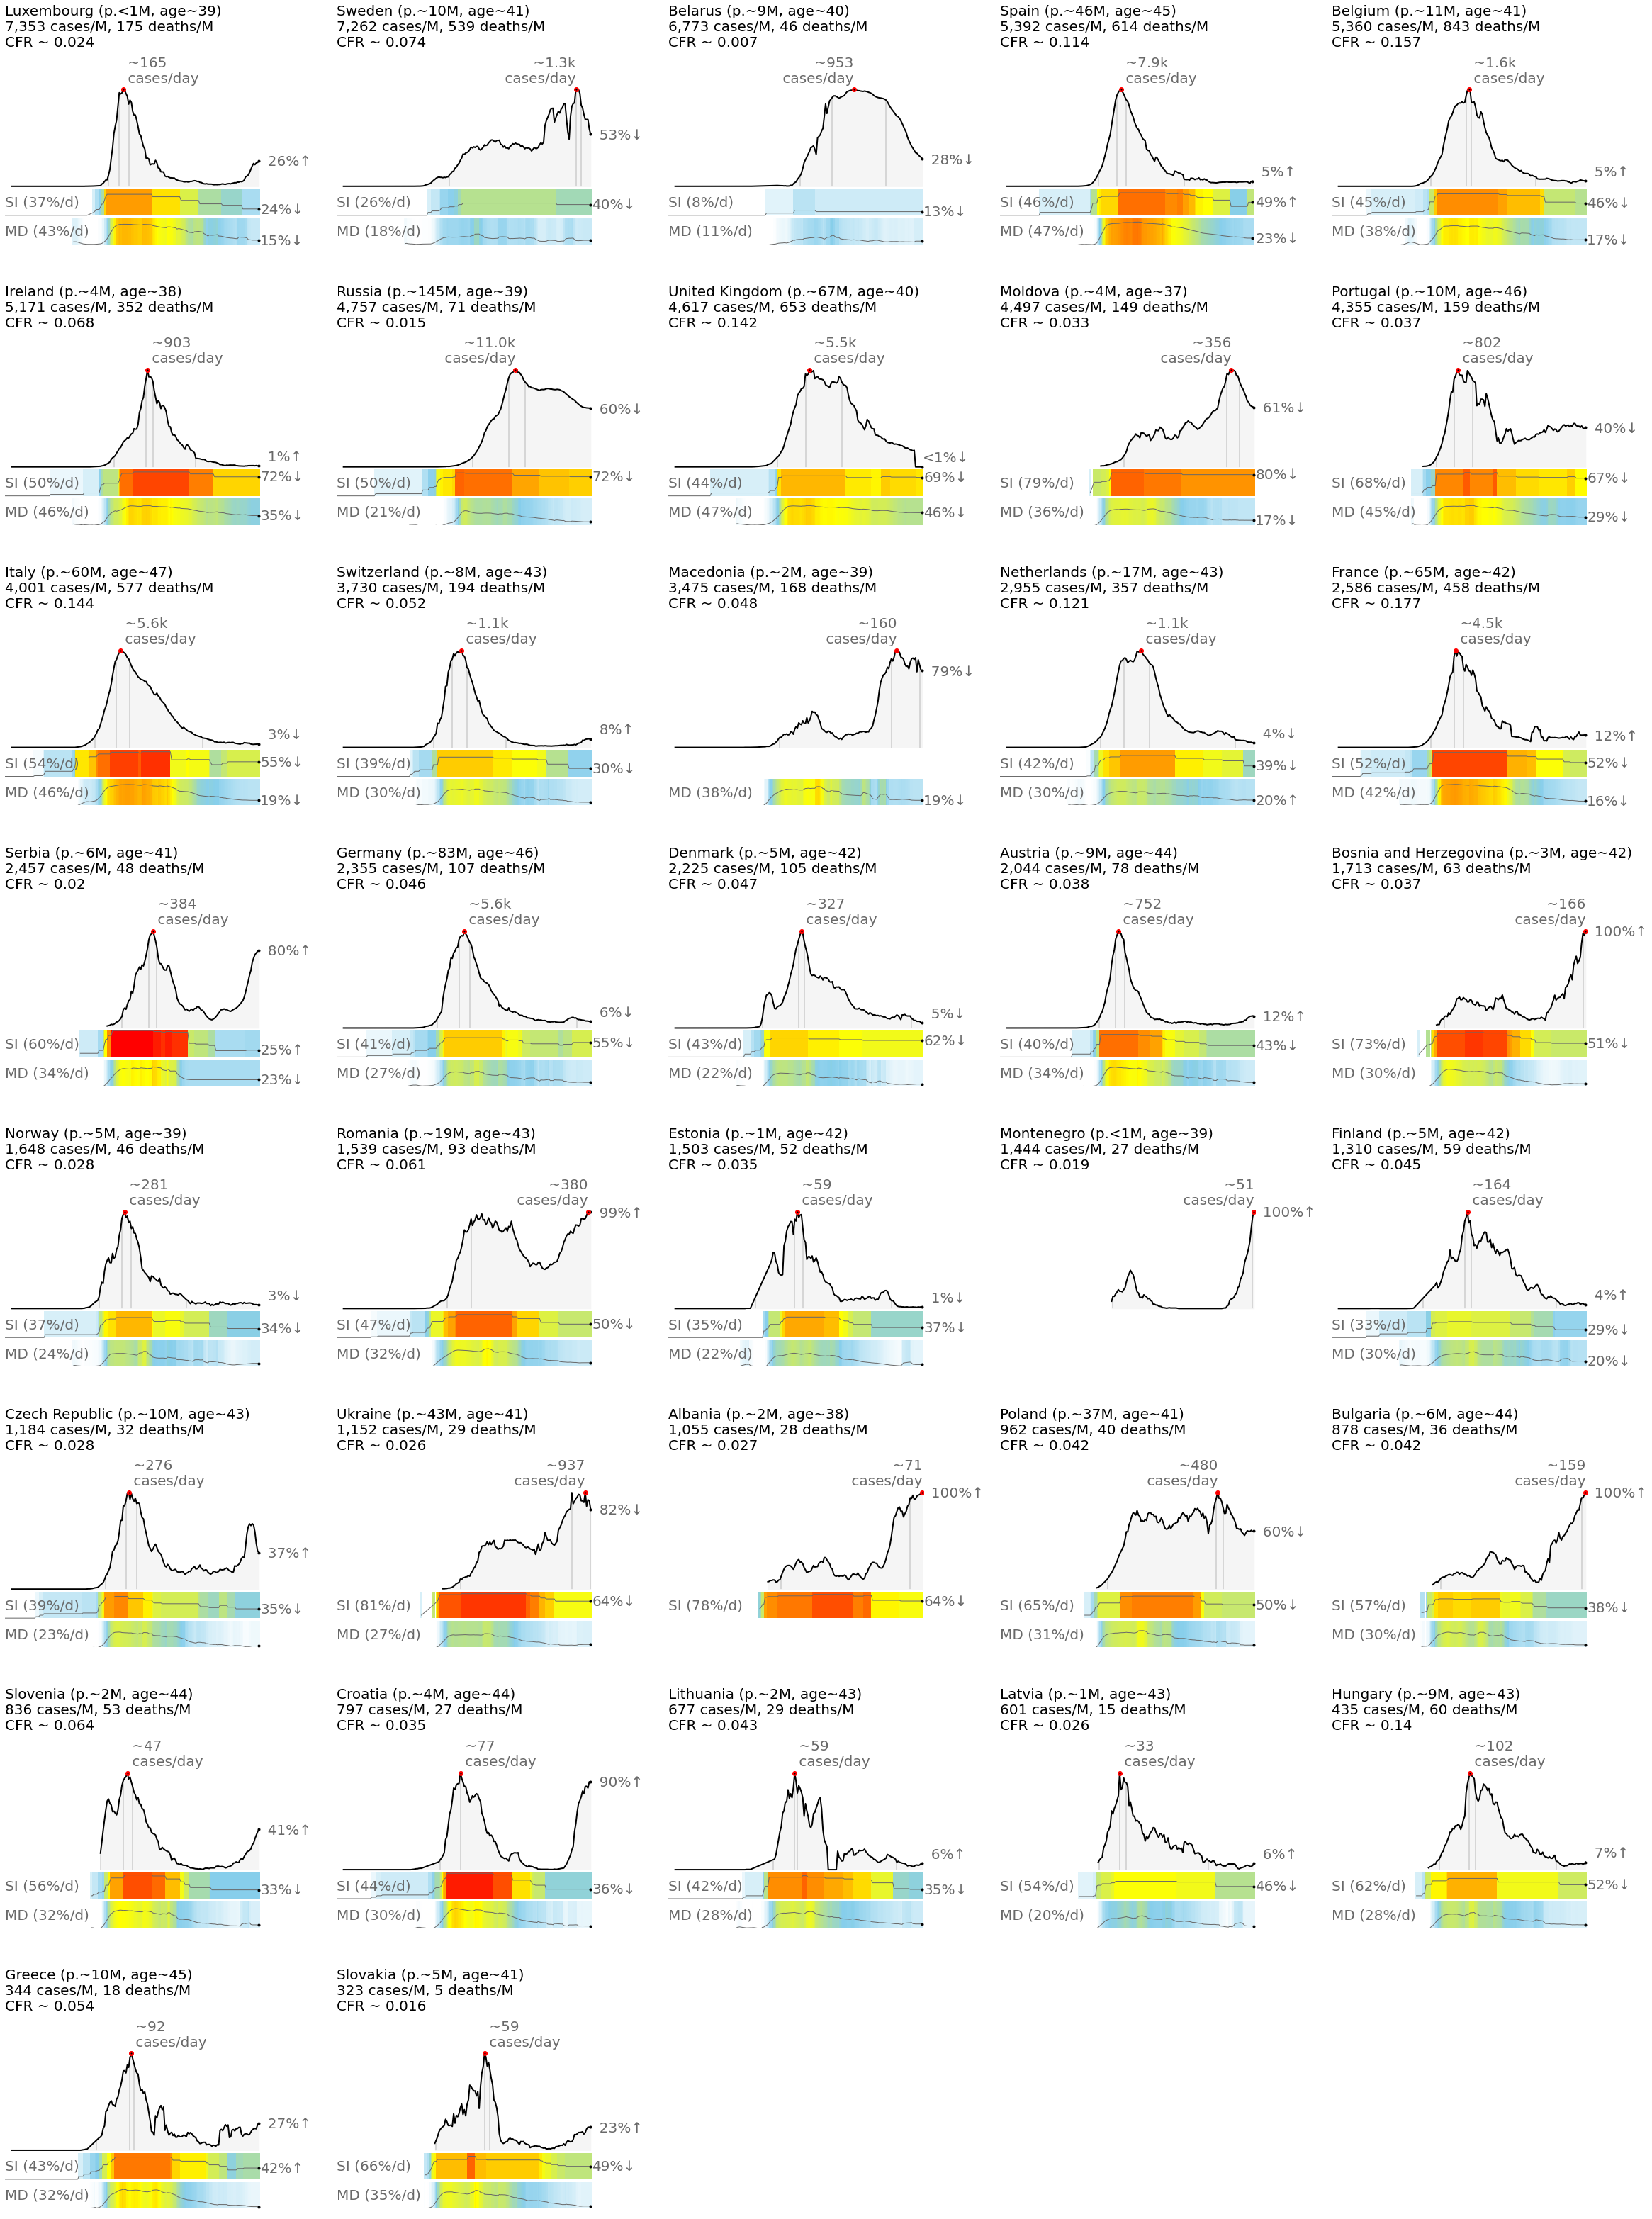

In [60]:
w, h = 8, 7
ncols, nrows = 5, 8

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for country, ax in zip(sorted_european_countries, axs.flatten()):
    
    data = df[df['country']==country].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/europe_cases_si_google_grid.png', format='png', dpi=200)

# Asia & Oceania

In [61]:
asia = df[(df['population']>min_pop) & ((df['continent']=='Asia')|(df['continent']=='Oceania'))]

total_cases_per_capita = asia.groupby('country')['total_cases_per_million'].max()

sorted_asia_countries = sorted(asia.country.unique(), key=lambda c: total_cases_per_capita[c], reverse=True)

len(sorted_asia_countries)

51

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


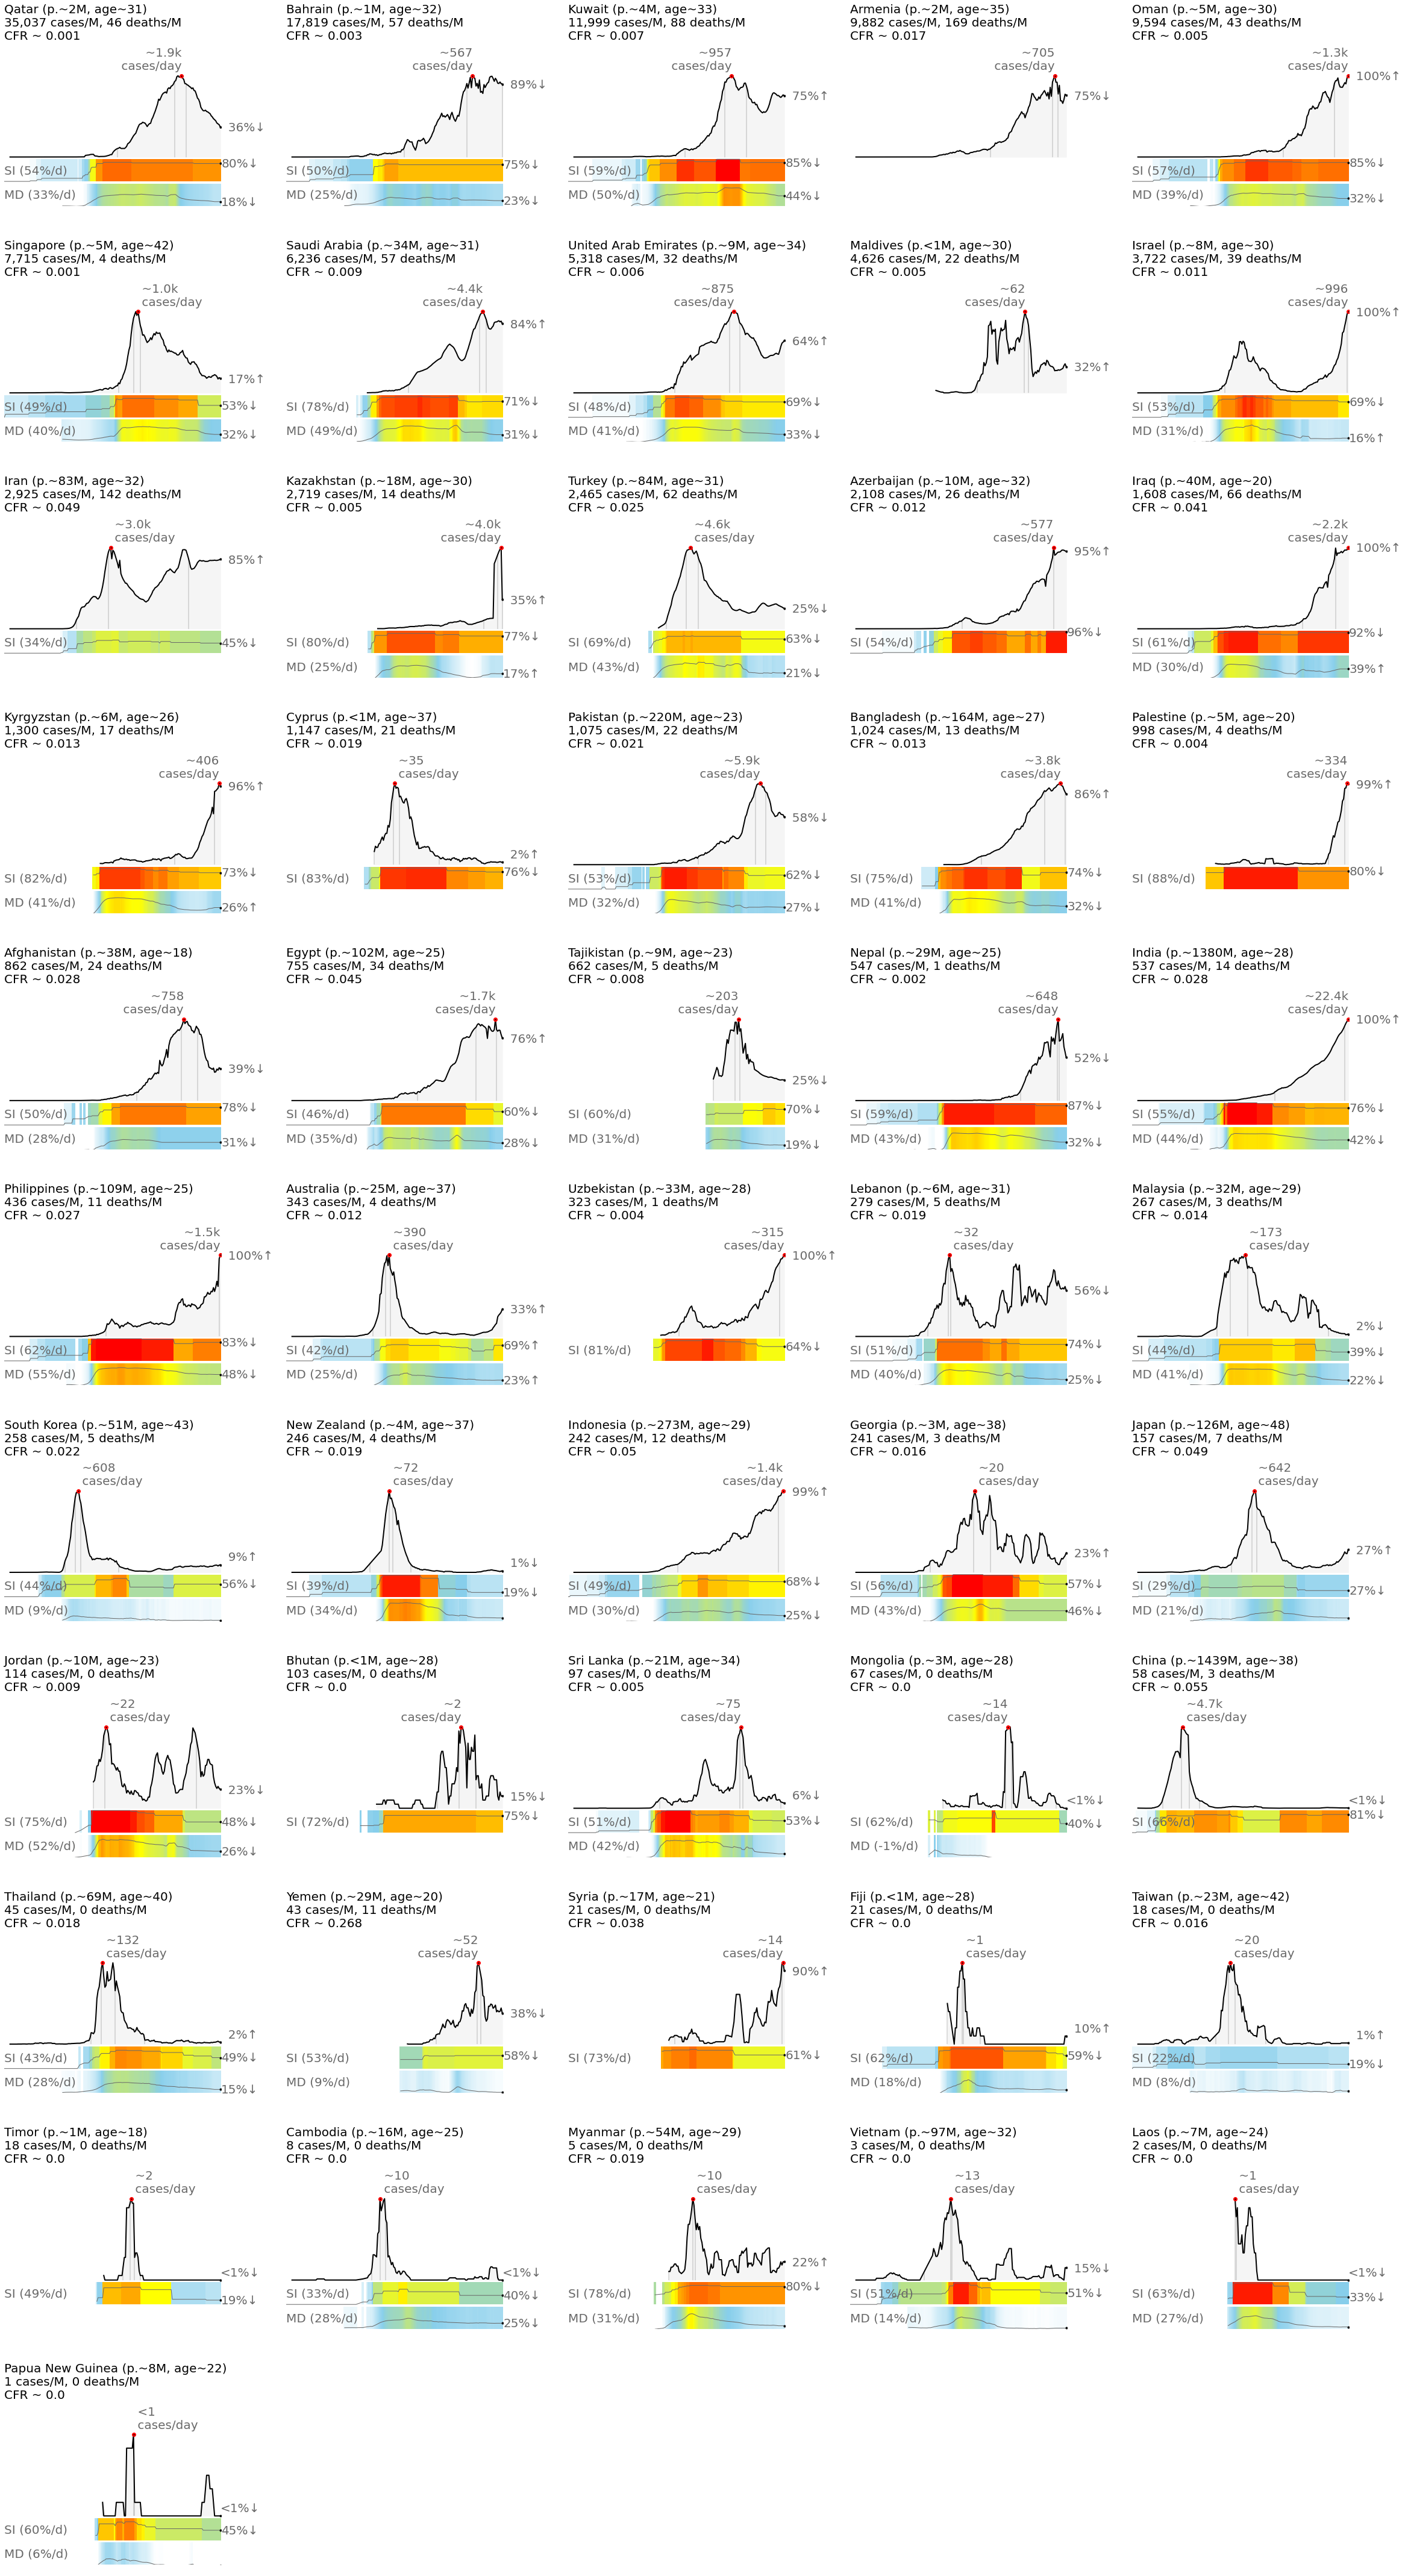

In [27]:
ncols, nrows = 5, 11

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for country, ax in zip(sorted_asia_countries, axs.flatten()):
    
    data = df[df['country']==country].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/asia_oceania_cases_si_google_grid.png', format='png', dpi=200)

# The Americas

In [28]:
americas = df[(df['population']>min_pop) & (df['continent'].str.contains('America'))]

total_cases_per_capita = americas.groupby('country')['total_cases_per_million'].max()

sorted_americas_countries = sorted(americas.country.unique(), key=lambda c: total_cases_per_capita[c], reverse=True)

len(sorted_americas_countries)

27

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


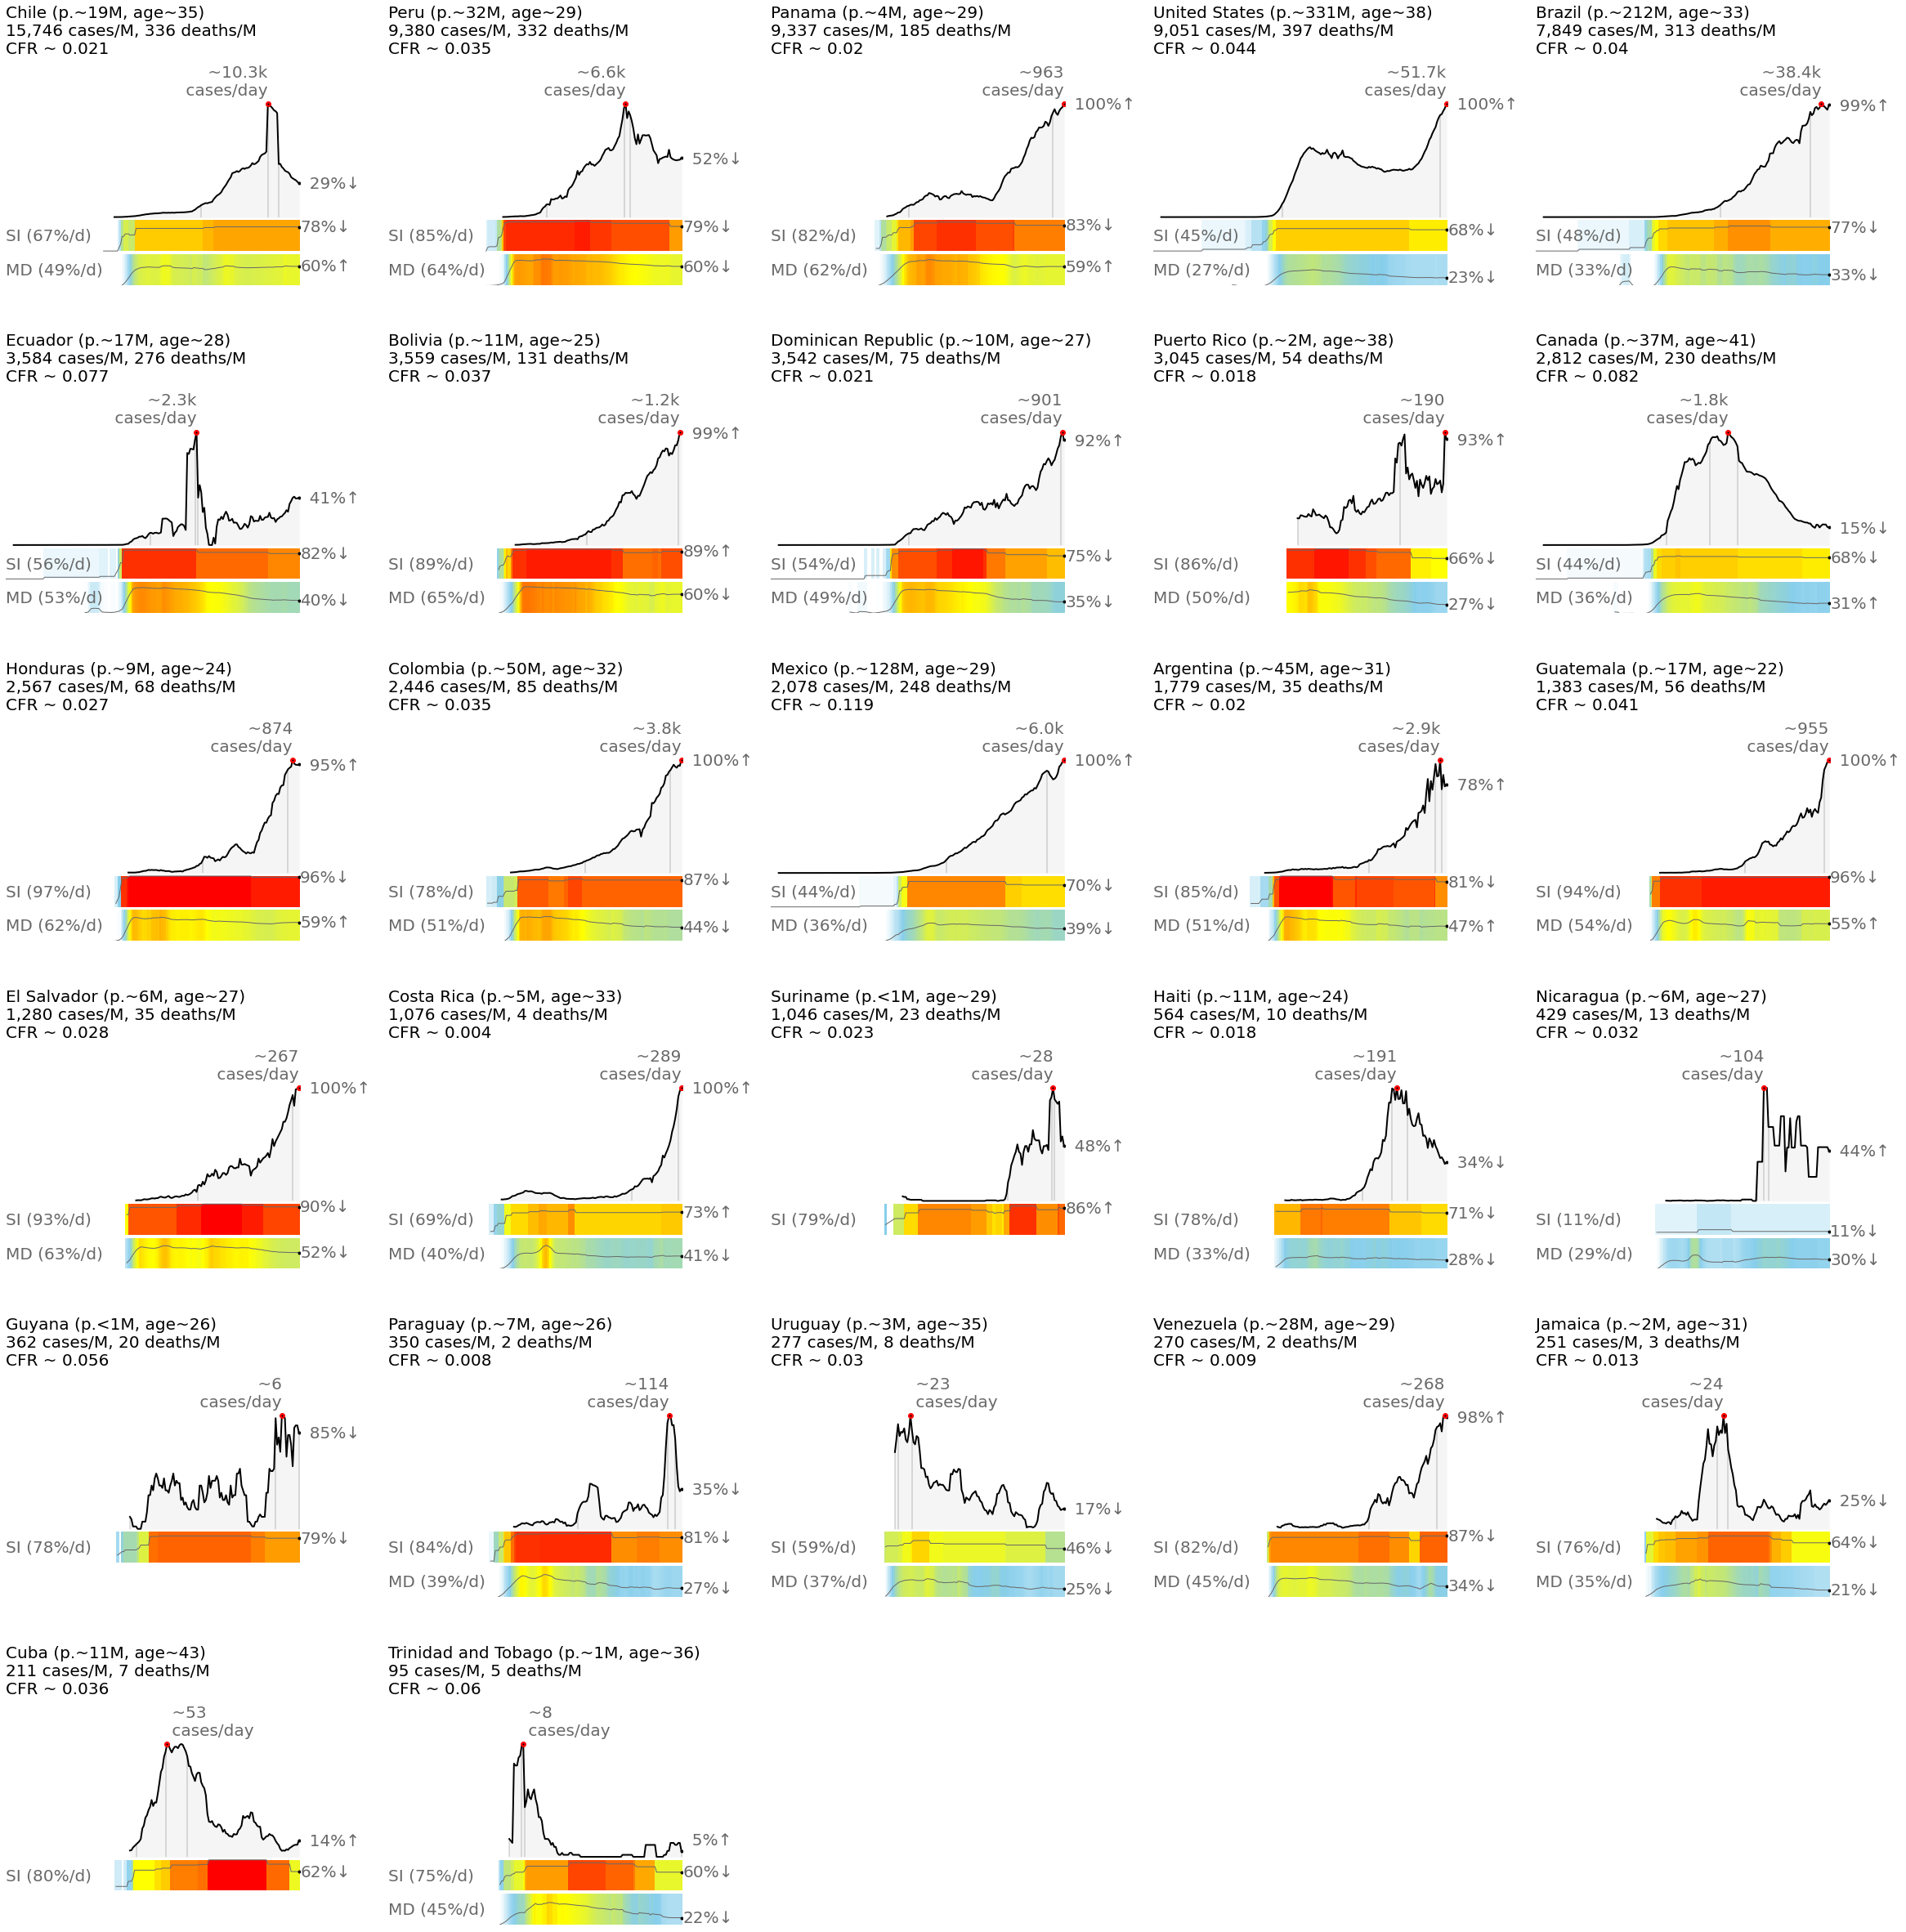

In [29]:
ncols, nrows = 5, 6

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for country, ax in zip(sorted_americas_countries, axs.flatten()):
    
    data = df[df['country']==country].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/americas_cases_si_google_grid.png', format='png', dpi=200)

# Africa

In [30]:
africa = df[(df['population']>min_pop) & (df['continent'].str.contains('Africa'))]

total_cases_per_capita = africa.groupby('country')['total_cases_per_million'].max()

sorted_africa_countries = sorted(africa.country.unique(), key=lambda c: total_cases_per_capita[c], reverse=True)

len(sorted_africa_countries)

52

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


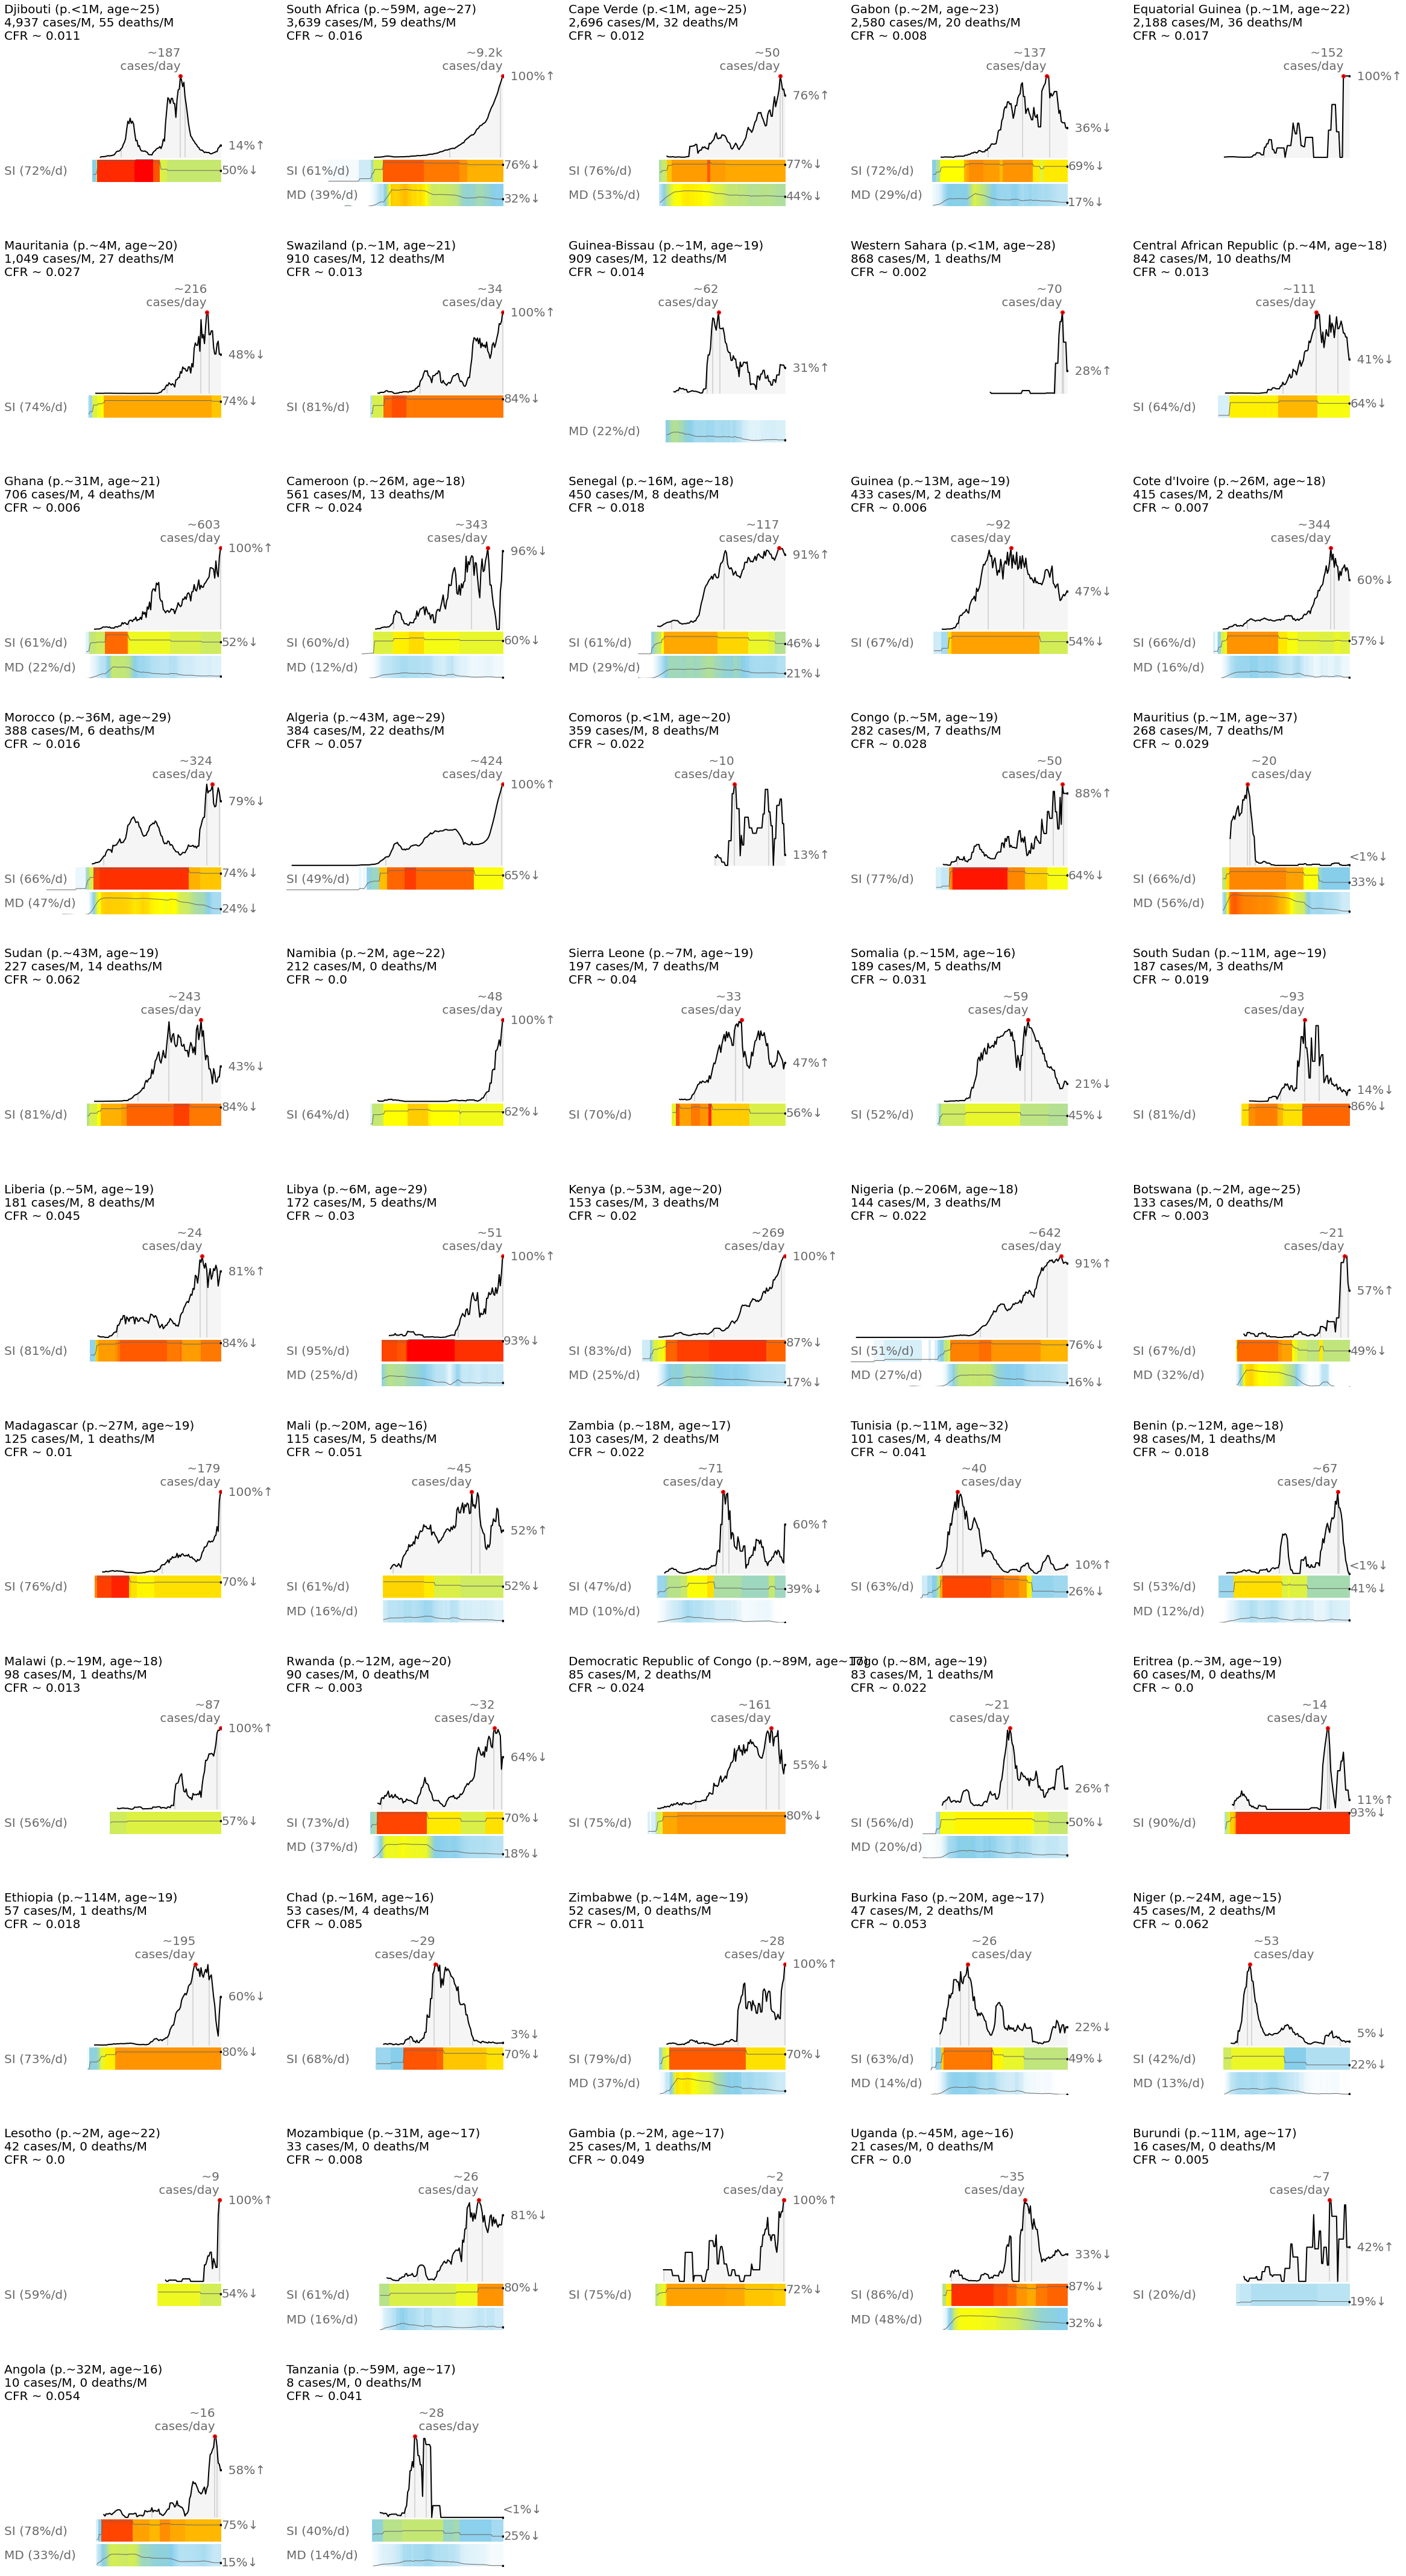

In [31]:
ncols, nrows = 5, 11

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for country, ax in zip(sorted_africa_countries, axs.flatten()):
    
    data = df[df['country']==country].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/africa_cases_si_google_grid.png', format='png', dpi=200)

# Global

In [32]:
with_si = df['stringency_index'].notnull()
with_mobility = df['google_rolling_mobility_drop'].notnull()



In [33]:
world = df[(df['population']>min_pop) & with_si & with_mobility]

total_cases_per_capita = world.groupby('country')['total_cases'].max()

sorted_world_countries = sorted(world.country.unique(), key=lambda c: total_cases_per_capita[c], reverse=True)

len(sorted_world_countries)

123

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


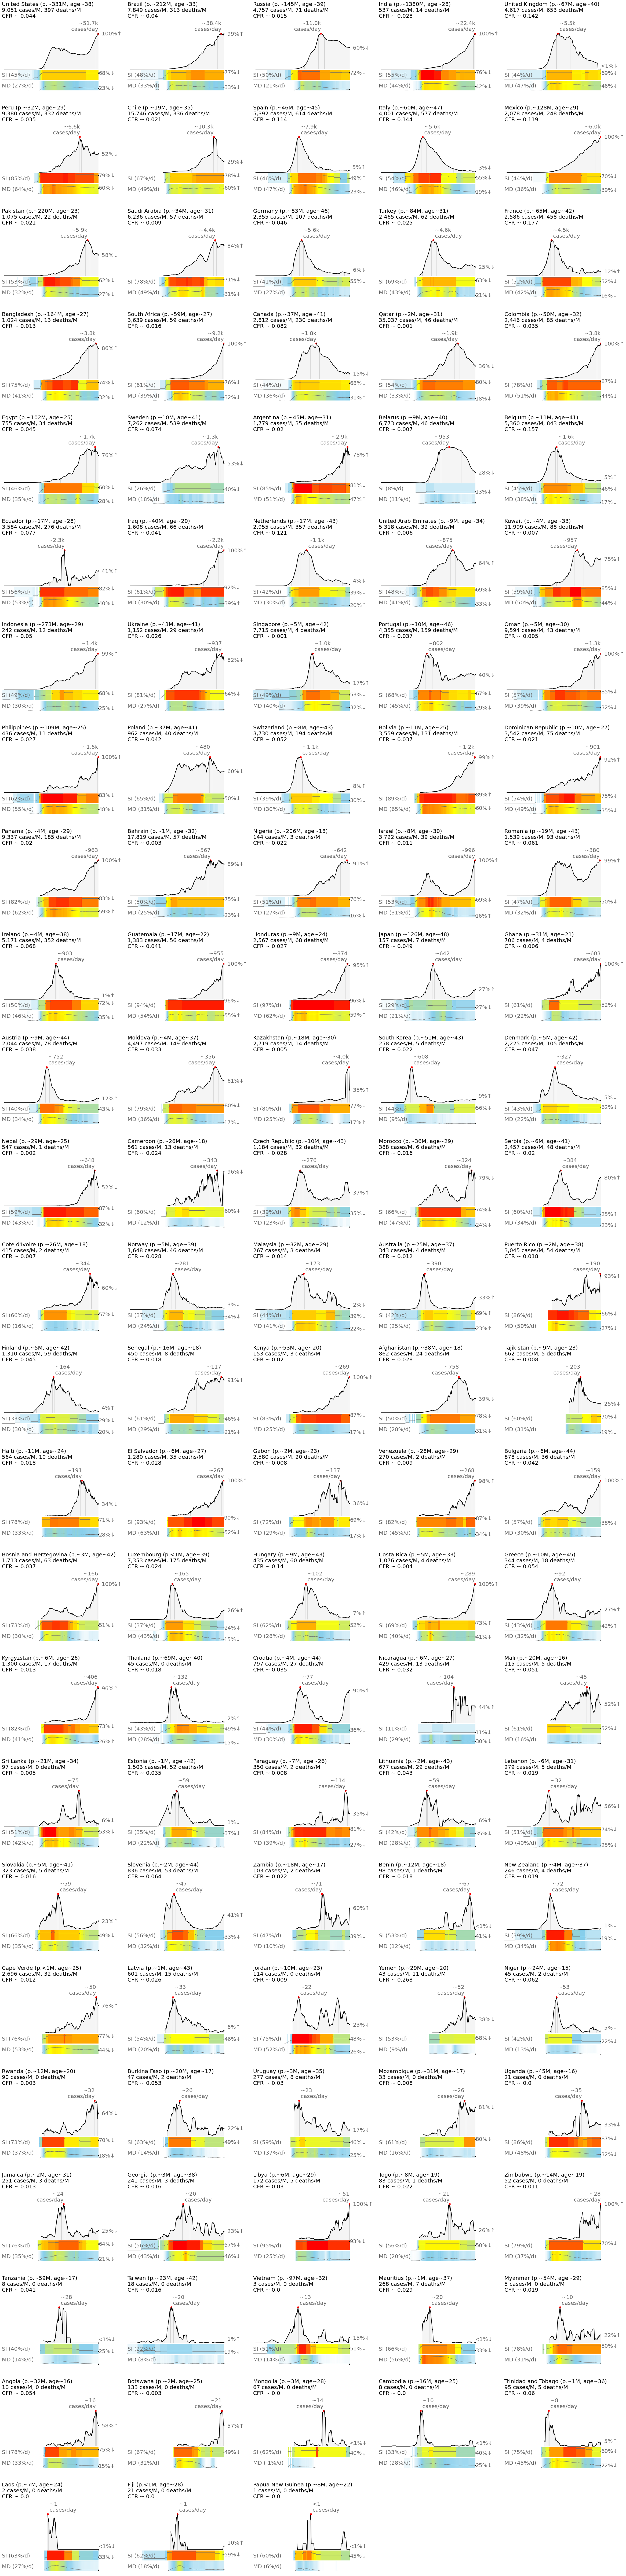

In [34]:
ncols, nrows = 5, 25

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for country, ax in zip(sorted_world_countries, axs.flatten()):
    
    data = df[df['country']==country].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/world_cases_si_google_grid.png', format='png', dpi=200)

In [35]:
assert False

AssertionError: 

In [19]:
current_rel_new_cases = df.groupby('country').last()['new_cases_rolling_mean']/df.groupby('country')['new_cases_rolling_mean'].max()

In [20]:
totals_per_country = df.groupby('country')[['new_cases_rolling_mean', 'new_cases_per_million_rolling_mean', 'stringency_index', 'google_rolling_mobility_drop']].sum()

In [21]:
current_rel_new_cases.corr(totals_per_country['stringency_index'])**2

0.13170925889193522

In [22]:
rebound_days = df[df['google_rolling_mobility_drop_stage']=='B'].groupby('country').size()

In [23]:
lockdowns_days = df.groupby(['country', 'stringency_index_stage']).size().unstack()
lockdowns_si = df.groupby(['country', 'stringency_index_stage'])['stringency_index'].mean().unstack()


# badly_hit = totals_per_country[(totals_per_country['new_cases_per_million_rolling_mean']>500) & (totals_per_country['new_cases_per_million_rolling_mean']<10000)]
long_holds = lockdowns_days[lockdowns_days['H']>28]
deep_holds = lockdowns_si[lockdowns_si['H']>50]
long_bounces = lockdowns_days[lockdowns_days['B']>28]

use_countries = set(long_holds.index).intersection(deep_holds.index).intersection(long_bounces.index)
len(use_countries)

57

In [24]:
use_countries

{'Andorra',
 'Aruba',
 'Australia',
 'Austria',
 'Benin',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Burkina Faso',
 'Chad',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cyprus',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Estonia',
 'Fiji',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Greenland',
 'Hungary',
 'India',
 'Iran',
 'Israel',
 'Italy',
 'Jordan',
 'Kyrgyzstan',
 'Laos',
 'Lithuania',
 'Luxembourg',
 'Mali',
 'Netherlands',
 'New Zealand',
 'Niger',
 'Norway',
 'Pakistan',
 'Papua New Guinea',
 'Paraguay',
 'Portugal',
 'Puerto Rico',
 'Romania',
 'Russia',
 'Rwanda',
 'Serbia',
 'Sierra Leone',
 'Slovenia',
 'Spain',
 'Switzerland',
 'Syria',
 'Thailand',
 'Timor',
 'United Arab Emirates',
 'Uzbekistan'}

In [25]:
data.reset_index().groupby('growth_stage_new_cases_rolling_mean').first()[['date']]

KeyError: 'growth_stage_new_cases_rolling_mean'

In [ ]:
transition_colours = ['white', 'green', 'yellow', 'red']
cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)

cmap(.5)

In [ ]:
sns.palplot(cmap(.2))

In [ ]:
((si_data/100)).max()

In [ ]:
(si_data/100).plot()

## The Growth Stages – Expansion, Peak, Contraction


In [ ]:
# The delta camn be calculated based on the number of transitions
# and adjusted so that it corresponds to the colour change transitions
# in the peak model.
peak_delta = 0.15  #1/(2*len(transition_colours))

min_contraction_days = 10

peak_delta

### Calculating the Stage Transitions

In [ ]:

def get_growth_model_dates(s, delta=peak_delta):
    """Identify the peak start and end dates; s is date indexed."""
    
    # The peak and peak date
    peak, peak_date = s.max(), s.idxmax()
    
    # pre and post peak
    pre, post = s.loc[:peak_date], s.loc[peak_date:].iloc[1:].iloc[::-1]  
   
    # The expansion starts when pre>delta*peak;
    expansion = pre[pre>delta*peak]
    expansion_start_date = expansion.index[0] if len(expansion)>0 else s.index[0]
    
    # The incubation stage starts when pre>0
    incubation = pre[pre>0]
    incubation_start_date = incubation.index[0] if len(incubation)>0 else False
    
    # The contraction ends on the last day where post>delta*peak
    contraction = post[post>delta*peak]
    contraction_end_date = contraction.index[0] if len(contraction)>0 else False
    
    # The stable stage starts after the contraction end date if there are days available.
    if contraction_end_date:
        stable_end_date =  s.index[-1] if (contraction_end_date < s.index[-1]) else False
    else:
        stable_end_date = False
    
    # The peak ends when post rises above (1-delta)*peak for the last time.
    peak_end = post[post>(1-delta)*peak]
    
    # If we have found the peak end...
    if len(peak_end)>0:
        peak_end_date = peak_end.index[0]
        
    # Else if there are post days but none are above the peak thershold
    # then it must mean that numbers dropped below teh peak on the day after
    # the peak
    elif len(post)>0:
        peak_end_date = post.index[-1]
    else:
        peak_end_date = False
            

    # -- new
    # Find the start of the peak stage. It the peak is not definitive then
    # this peak start is subject to change, especially if numbers are growing.
    pre = pre.loc[expansion_start_date:]
    peak_start = pre[pre>(1-delta)*peak]
    peak_start_date = peak_start.index[0] if len(peak_start)>0 else False    
    
    # The peak is only valid if the current date is > min_contraction_days beyond the end of the peak. 
    if (peak_end_date is False):
    
        # No end peak was located
        return incubation_start_date, expansion_start_date, peak_date, peak_start_date, s.index[-1], False, False
    
    elif (s.index[-1]-peak_end_date).days < min_contraction_days:
        
        # And end peak was located but its too close to the current date to be certain.
        return incubation_start_date, expansion_start_date, peak_date, peak_start_date, s.index[-1], False, False
        
    # Otherwise peak is valid so find the start of the peak stage and finish.
    else:  
        return incubation_start_date, expansion_start_date, peak_date, peak_start_date, peak_end_date, contraction_end_date, stable_end_date


def get_growth_model_stages(s):
    
    if len(s)>0:
                
        stages = pd.Series([np.nan]*len(s), index=s.index)
        
        stage_dates = get_growth_model_dates(s)
                
        incubation_start_date, expansion_start_date, peak_date, peak_start_date, peak_end_date, contraction_end_date, stable_end_date = stage_dates
        
        if incubation_start_date:
            stages.loc[incubation_start_date: expansion_start_date] = 'I'
        
        if peak_start_date:
            expansion_end_date = peak_start_date - datetime.timedelta(days=1)
            stages.loc[expansion_start_date:expansion_end_date] = 'E'
            
            if peak_end_date:
                contraction_start_date = peak_end_date + datetime.timedelta(days=1)
                stages.loc[peak_start_date:peak_end_date] = 'P'
                stages.loc[contraction_start_date:] = 'C'
            
            else:
                stages.loc[peak_start_date:] = 'P'
                
        if stable_end_date:
            stages.loc[contraction_end_date: stable_end_date] = 'S'

        return stages

### Assigning the Stages

In [ ]:
def assign_growth_stages(df, col, groupby):
    
    growth_stage_col = 'growth_stage'+'_'+col
    
    # Generate the lockdown phases series for each country
    growth_stages = pd.DataFrame(
        df.groupby(groupby).apply(
            lambda g: get_growth_model_stages(g.set_index('date')[col].dropna())
        ), columns=[growth_stage_col]
    )
    
    df = df.set_index([groupby, 'date']).join(growth_stages).reset_index()
        
    # Add stage days
    growth_stage_days = pd.DataFrame(
        df.groupby([groupby, growth_stage_col]).apply(
            lambda g: pd.Series(range(1, len(g)+1), index=g['date'])),
        columns=[growth_stage_col+'_day']
    )
    
    return df.set_index([groupby, growth_stage_col, 'date']).join(growth_stage_days).reset_index()
    
    
    

In [ ]:
df = assign_growth_stages(df, 'new_cases_rolling_mean', 'country')
df = assign_growth_stages(df, 'new_deaths_rolling_mean', 'country')

df.tail()

# Visualising Growth Models

## Plotting Single Growth Models

In [ ]:

def plot_ext_peak_model(ax, data, stages=None, show_labels=False, show_landmarks=True, title=None):
    """Plot a single growth model based on date indexed data and stages."""
    
    # Calculate the max and relative data
    peak, peak_date, total = data.max(), data.idxmax(), data.sum()
    rel = data/peak
    
    # The start and end date of the graph
    start, end = datetime.date(2020, 1, 1), datetime.date.today()
    

    # Plot the coloured bar chart and the outline line.
    ax.fill_betweenx(rel, rel.index, color='whitesmoke')
    ax.plot(rel.index, rel, lw=1, c='k')
    
    if show_landmarks:
        
        # Add the growth stages
        stage_start_dates = stages.reset_index().groupby(
            stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()
        
        stage_start_dates['date'].map(
            lambda start_date: ax.axvline(start_date, lw=1, ls='--', c='k'))
        
        ax.axhline(peak_delta, lw=1, ls='--', c='k')
        ax.axhline(1-peak_delta, lw=1, ls='--', c='k')
        
        # The number of days since the peak start
        days_since_peak_start = (datetime.datetime.today()-pd.to_datetime(stage_start_dates.loc['P'].values[0])).days

        # If the peak is definitive (Contraction has started proper) the we have a peak duration.
        if 'C' in stage_start_dates.index:
            peak_duration = pd.to_timedelta(stage_start_dates.loc['C'].values[0]-stage_start_dates.loc['P'].values[0]).days
            peak_text = '{}d, {}d ago'.format(peak_duration, days_since_peak_start)
            
        # Otherwise, if thepeak phase is ongoing then th epeak duration is tentative.
        else:
            peak_duration = pd.to_timedelta(data.index[-1]-stage_start_dates.loc['P'].values[0]).days+1
            peak_text = '{}d ago'.format(days_since_peak_start)


        if title is not None:
            if peak >999:
                peak_value = '~{}k'.format(round(peak/1000, 1))
            elif peak<1:
                peak_value = '<1'
            else:
                peak_value = '~{}'.format(int(peak))
            ax.set_title(
                '{}\nPeak {} ({})\nTotal ~{:,}'.format(title, peak_value, peak_text, int(total)), 
                loc='left', ha='left')

    else:         
        ax.axis('off')
        
    if show_labels:
        
        # Label the stages
        stage_start_dates = stages.reset_index().groupby(
            stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()
        stage_start_dates.apply(lambda row: ax.annotate(row.name, xy=(row['date']+datetime.timedelta(days=1.1), 1.01)), axis=1)
        
        # Label the thresholds
        ax.annotate('{}% of Peak'.format(int(100*peak_delta)), xy=(start+datetime.timedelta(days=2), .02+peak_delta))
        ax.annotate('{}% of Peak'.format(int(100*(1-peak_delta))), xy=(start+datetime.timedelta(days=2), .02+(1-peak_delta)))

    # Finalise the axes.
    ax.set_xlim(start, end)
    ax.set_ylim(0, 1.09)
    ax.set_yticks(np.arange(0, 1.1, .5))
    
    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[:1]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
    
    return peak, peak_date






In [ ]:
def plot_ext_peak_model_for_group(ax, data, col, show_labels=False, show_landmarks=True, title=None):
    
    """Plot a single growth model for a collection of data."""
    
    summed_data = data.groupby('date')[col].sum()
    
    growth_stages = get_growth_model_stages(summed_data)
    
    peak, peak_date = plot_ext_peak_model(ax, summed_data, growth_stages, show_labels=show_labels,  show_landmarks=show_landmarks, title=title)
    
    return peak, peak_date, summed_data, growth_stages



In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(3, 1.5))

ireland = df[df['country']=='Ireland']

col = 'new_cases_rolling_mean'

peak, peak_date, _, _ = plot_ext_peak_model_for_group(ax, ireland, col, show_landmarks=False, title='Ireland')

ax.axis('off')

fig.tight_layout()

peak, peak_date

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1.5))

i = ireland.groupby('date')['new_cases_rolling_mean'].sum()

ax.fill_betweenx(i, i.index)

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))

data = df[df['country']=='Ireland']

col = 'new_cases_rolling_mean'
title = 'Ireland (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))


peak, peak_date, _, _ = plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_labels=True, show_shading=True, show_landmarks=True, title=title)

ax.axis('on')

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

fig.savefig('../graphs/ireland_cases.png', dpi=150, format='png', bbox_inches="tight")

peak, peak_date

### Global Cases

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))


data = df
col = 'new_cases_rolling_mean'

title = 'Worldwide (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()/1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

fig.tight_layout()

fig.savefig('../graphs/worldwide_cases.png', dpi=150, format='png', bbox_inches="tight")

### European Cases

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))

data = df[df['continent']=='Europe']
col = 'new_cases_rolling_mean'

title = 'All Europe (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

fig.tight_layout()

fig.savefig('../graphs/europe_cases.png', dpi=150, format='png', bbox_inches="tight")

In [ ]:
eu = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 
    'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))

data = df[df['country'].isin(eu)]
col = 'new_cases_rolling_mean'

title = 'The EU (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_labels=True, show_shading=True, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

fig.savefig('../graphs/eu_cases.png', dpi=150, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))

data = df[(df['continent']=='Europe') & (~df['country'].isin(eu))]
col = 'new_cases_rolling_mean'

title = 'Non-EU Europe (pop. {:,})'.format(int(data.groupby('country').first().population.sum()))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

fig.savefig('../graphs/non_eu_cases.png', dpi=150, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5.4))


data = df[df['country']=='United States']
col = 'new_cases_rolling_mean'

title = 'US (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

fig.savefig('../graphs/us_cases.png', dpi=150, format='png', bbox_inches="tight")

## Models x Continent

In [ ]:
sns.set_context('talk')

fig, axs = plt.subplots(figsize=(14, 13), nrows=3, ncols=2, sharex=True, sharey=True)

axs = axs.flatten()

col = 'new_cases_rolling_mean'

for continent, ax in zip(df['continent'].unique(), axs):
    
    data = df[df['continent']==continent]
    col = 'new_cases_rolling_mean'

    title = '{} (pop. {:,})'.format(continent, int(data.groupby('country').first().population.sum()))
    plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)



axs[0].set_ylabel('Relative Daily Cases')
axs[2].set_ylabel('Relative Daily Cases')

axs[4].set_xlabel('Month')
axs[5].set_xlabel('Month')

fig.tight_layout()

fig.savefig('../graphs/continents_by_cases.png', dpi=150, format='png', bbox_inches="tight")

## A bar grid of growth models by continent

In [ ]:

def plot_bar_grid(df, x_col, y_col, value_col, cmap=cmap, w=2, h=2):
    
    growth_stage_col = 'growth_stage_'+value_col
    
    num_cols = df[x_col].nunique()
    num_rows = df.groupby(x_col)[y_col].nunique().max()
            
    # Sort rows by peak date; need to aggregate by dates first in case of groups of countries.
    peak_dates = df.groupby([x_col, y_col, 'date']).apply(
        lambda g: g.set_index('date')[[value_col]].sum()).reset_index().groupby([x_col, y_col]).apply(
            lambda g: g.set_index('date')[value_col].idxmax()).map(
                lambda dt: (datetime.datetime(2020, 1, 1)-dt).days).groupby(x_col).mean()    
    
    sorted_cols = sorted(df[x_col].unique(), key=lambda x: peak_dates.loc[x], reverse=True)

    fig, axs = plt.subplots(
        figsize=(w*num_cols, h*num_rows), ncols=num_cols, nrows=num_rows,
        gridspec_kw={'hspace': 0.75,},
        sharex=True, sharey=True
    )

    # Turn all graph frames off
    for row_num in range(num_rows): 
        for col_num in range(num_cols): 
            axs[row_num, col_num].axis('off')

    for col_num, col_name in enumerate(sorted_cols):
                
        row_names = df[df[x_col]==col_name][y_col].unique()

        sum_values = df[df[x_col]==col_name].groupby(y_col)[value_col].sum()
        sorted_rows = sorted(row_names, key=lambda y: sum_values.loc[y], reverse=True)

        for row_num, row_name in enumerate(sorted_rows):
            
            print(col_name, row_name)

            rev_row = (num_rows-1) - row_num
                      
            # The data for the current graph
            data = df[(df[x_col]==col_name) & (df[y_col]==row_name)].set_index('date')
                        
            # Construct the graph title
            max_chars = 18
            title = row_name.replace('_', ' ').title()
            pop = int(data.groupby('country').first().population.sum())//1000000
            pop = '{:,}M'.format(pop) if pop>0 else '<1M'
            
            short_title = title if len(title)<max_chars else title[:max_chars]+'…'
            short_title = '{} ({})'.format(short_title, pop)
            
            # Plot the graph
            plot_ext_peak_model_for_group(axs[rev_row, col_num], data, value_col, cmap=cmap, show_landmarks=True, title=short_title)
            
            # Add axis border and ticks
            axs[rev_row, col_num].axis('on')
            axs[rev_row, col_num].tick_params(axis=u'both', which=u'both',length=0)
            
    # Add the column labels
    for i, name in enumerate(sorted_cols):
        short_name = name.replace('_', ' ').title()
        short_name = short_name if len(short_name)<22 else short_name[:max_chars]+'…'
        axs[num_rows-1, i].set_xlabel(short_name, fontsize=18)
        
    print('Finished')
        
    return fig, axs
        




# Continents x Regions

In [ ]:
countries_with_cases = df['country'].isin(max_new_cases_for_countries[max_new_cases_for_countries>min_cases].index)
countries_with_deaths = df['country'].isin(max_new_deaths_for_countries[max_new_deaths_for_countries>min_deaths].index)

df[countries_with_cases].country.nunique(), df[countries_with_deaths].country.nunique()

## Continents x Regions x Cases

In [ ]:
sns.set_context('paper', font_scale=1.4)

w, h = 4, 2.7

fig, axs = plot_bar_grid(df[countries_with_cases], 'continent', 'region', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Continents & Regions ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/continents_by_regions_bar_grid_cases.png', dpi=150, format='png', bbox_inches="tight")

In [ ]:
current_growth_stages = df.groupby(['continent', 'region', 'country']).last().filter(regex='new_cases_rolling_mean|new_cases_per_million_rolling_mean|population')

past_peak = current_growth_stages[(current_growth_stages['growth_stage_new_cases_rolling_mean']=='C') | ((current_growth_stages['growth_stage_new_cases_rolling_mean']=='S'))]

past_peak['population'].sum()/current_growth_stages['population'].sum()

In [ ]:
len(past_peak)/len(current_growth_stages)

In [ ]:
past_peak.reset_index().region.unique()

## Continents x Regions x Deaths

In [ ]:
sns.set_context('paper', font_scale=1.4)

w, h = 4, 2.7

fig, axs = plot_bar_grid(df[countries_with_deaths], 'continent', 'region', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Deaths (7d rolling average) by Day for Continents & Regions ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/continents_by_regions_bar_grid_deaths.png', dpi=300, format='png', bbox_inches="tight")

# Asia

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_cases & ((df['continent']=='Asia') | (df['continent']=='Oceania'))]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)


# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Asia ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/asia_oceania_bar_grid_cases.png', dpi=200, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_deaths & ((df['continent']=='Asia') | (df['continent']=='Oceania'))]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/asia_oceania_bar_grid_deaths.png', dpi=200, format='png', bbox_inches="tight")

## Africa

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_cases & (df['continent']=='Africa')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)


# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Africa & Oceania ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )
fig.tight_layout()

fig.savefig('../graphs/africa_bar_grid_cases.png', dpi=200, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_deaths & (df['continent']=='Africa')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)


fig.savefig('../graphs/africa_bar_grid_deaths.png', dpi=200, format='png', bbox_inches="tight")

## Europe

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_cases & (df['continent']=='Europe')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Europe ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/europe_bar_grid_cases.png', dpi=200, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_deaths & (df['continent']=='Europe')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Europe ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/europe_bar_grid_deaths.png', dpi=200, format='png', bbox_inches="tight")

## North & South America 

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_cases & (df['continent']=='North America')|(df['continent']=='South America')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)


fig.tight_layout()

fig.savefig('../graphs/north_south_america_bar_grid_cases.png', dpi=200, format='png', bbox_inches="tight")

In [ ]:
sns.set_context('paper', font_scale=1.5)

w, h = 4, 2.7

data = df[countries_with_deaths & (df['continent']=='North America')|(df['continent']=='South America')]

fig, axs = plot_bar_grid(data, 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/north_south_america_bar_grid_deaths.png', dpi=200, format='png', bbox_inches="tight")

In [ ]:
df['country'].nunique()

In [ ]:
assert false

In [ ]:
sns.set_context('paper', font_scale=1.4)

fig, axs = plot_bar_grid(df[countries_with_cases], 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

fig.suptitle(
    'Daily Cases (7d rolling average) by Day for Regions & Countries ({})'.format(
        datetime.datetime.today().strftime('%d, %b %Y')), 
    fontsize=36
)

fig.tight_layout()

fig.savefig('../graphs/regions_by_countries_bar_grid_cases.png', dpi=200, format='png')

In [ ]:
sns.set_context('paper', font_scale=1.25)

fig, axs = plot_bar_grid(df[countries_with_deaths], 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)


fig.suptitle(
    'Daily Deaths (7d rolling average) by Day for Regions & Countries ({})'.format(
        datetime.datetime.today().strftime('%d, %b %Y')), 
    fontsize=36
)
fig.tight_layout()

fig.savefig('../graphs/regions_by_countries_bar_grid_deaths.png', dpi=300, format='png')

In [ ]:
sns.set_context('paper', font_scale=1.3)

fig, axs = plot_bar_grid(df[countries_with_cases], 'continent', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Cases (7d rolling average) by Day for Continents & Countries ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )
fig.tight_layout()

fig.savefig('../graphs/continents_by_countries_bar_grid_cases.png', dpi=300, format='png')

In [ ]:
sns.set_context('paper', font_scale=1)

fig, axs = plot_bar_grid(df[countries_with_deaths], 'continent', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

# fig.suptitle(
#     'Daily Deaths (7d rolling average) by Day for Continents & Countries ({})'.format(
#         datetime.datetime.today().strftime('%d, %b %Y')), 
#     fontsize=20
# )

fig.tight_layout()

fig.savefig('../graphs/continents_by_countries_bar_grid_deaths.png', dpi=300, format='png')

In [ ]:
num_rows

In [ ]:
assert False

In [ ]:
df[df['region']=='northern_europe']['country'].unique()

In [ ]:
continents = ['Europe']

ddf = df[df['continent'].isin(continents)]  #df[df['region'].isin(['east_africa', 'southern_africa', 'oceania', 'south_america', 'north_america', 'middle_east'])]

num_regions = ddf['region'].nunique()
max_countries = ddf.groupby('region')['country'].nunique().max()

w, h = 2, 1.5

peak_date_per_region = ddf.groupby(['region', 'country']).apply(lambda g: g.set_index('date')['new_cases_rolling_mean'].idxmax()).map(
    lambda dt: (datetime.datetime(2020, 1, 1)-dt).days).groupby('region').mean()
duration_cases_per_region = ddf.groupby(['region', 'country']).size().groupby('region').mean()

sorted_rows = sorted(ddf['region'].unique(), key=lambda region: peak_date_per_region.loc[region], reverse=True)

values_col = 'new_cases_rolling_mean'
growth_stage_col = 'growth_stage_'+values_col


fig, axs = plt.subplots(figsize=(w*num_regions, h*max_countries), ncols=num_regions, nrows=max_countries, sharex=True, sharey=True)

# Turn all graph frames off
for row in range(num_regions):
    for col in range(max_countries):
        axs[col, row].axis('off')
        

for row, region in enumerate(sorted_rows):
    
    countries = ddf[ddf['region']==region]['country'].unique()
    
    total_cases_per_country = ddf[ddf['region']==region].groupby('country')['total_cases'].max()
    sorted_cols = sorted(countries, key=lambda country: total_cases_per_country.loc[country], reverse=True)

    for col, country in enumerate(sorted_cols):
                
        rev_col = (max_countries-1) - col
                
        data = ddf[ddf['country']==country].set_index('date')
        plot_ext_peak_model(axs[rev_col, row], data[values_col], data[growth_stage_col], show_landmarks=False)
        
        max_chars = 15
        short_title = country if len(country)<max_chars else country[:max_chars]+'…'
        axs[rev_col, row].set_title(short_title)
        
        axs[rev_col, row].axis('on')
        axs[rev_col, row].tick_params(axis=u'both', which=u'both',length=0)
        


fig.tight_layout()

fig.savefig('../graphs/growth_models_grid_{}.png'.format('_'.join(continents)), dpi=600, format='png')

## Summarising Growth Models

In [ ]:
epcs_colours = ['orange', 'red', 'yellow', 'green']

#### Actual Growth Days
For each continent/country we calculate the number of days in each growth stage; we drop the I stage.

In [ ]:
growth_stages = ['I', 'E', 'P', 'C', 'S']

def get_growth_stage_days(df, col='growth_stage_new_cases_rolling_mean'):

    growth_stage_days = df.groupby(['continent', 'region', 'country', col]).size().unstack()[growth_stages].fillna(0)

    growth_stage_days = growth_stage_days.drop(labels=['I'], axis=1)

    return growth_stage_days

get_growth_stage_days(df).head()

In [ ]:
sns.set_context('paper', font_scale=1.5)

epcs_colours = ['orange', 'red', 'yellow', 'green']

fig, ax = plt.subplots(figsize=(10, 4))

get_growth_stage_days(df).groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, color=epcs_colours)

ax.set_ylim(-.5, 6.5)
# ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Number of COVID-19 Days')

fig.tight_layout()

#### Relative Growth Days
A relative version of growth days per stage.

In [ ]:
get_growth_stage_days(df).apply(lambda x: x/x.sum(), axis=1).head()

In [ ]:
def get_growth_stage_status(df, col='growth_stage_new_cases_rolling_mean'):
    
    # Get the growth stages
    growth_stage_days = get_growth_stage_days(df, col='growth_stage_new_cases_rolling_mean')
                 
    # The growth stage rules
    peaked = (growth_stage_days['C']>0)
    stable = growth_stage_days['S']>0
    contracting = (growth_stage_days['C']>0) & ~stable
    expanding = (growth_stage_days['P']>0) & ~contracting & ~stable
    
    growth_stage_status = pd.concat([peaked, expanding, contracting, stable], axis=1)
    growth_stage_status.columns = ['P', 'E', 'C', 'S']
    
    return growth_stage_status

get_growth_stage_status(df).head()

# Growth Stage RQs

## How many have peaked, stablised etc.

In [ ]:
growth_status = get_growth_stage_status(df)

growth_status.mean()

In [ ]:
growth_status.groupby('continent').mean().sort_values(by='P', ascending=False)

In [ ]:
growth_status.groupby('region').mean().sort_values(by='P', ascending=False)

## Of those that have peaked, how far off their peak are they?

In [ ]:
peaked = growth_status[growth_status['P']]

peaked.head()

### ... in terms of days

In [ ]:
growth_stage_days = get_growth_stage_days(df)
mean_post_peak_days = growth_stage_days.loc[peaked.index][['C', 'S']].sum(axis=1)

mean_post_peak_days.mean()

In [ ]:
mean_post_peak_days.groupby('continent').mean().sort_values(ascending=False)

In [ ]:
mean_post_peak_days.groupby('region').mean().sort_values(ascending=False)

### ... and in terms of fraction of peak 

In [ ]:
peak = df.set_index(['continent', 'region', 'country']).loc[peaked.index].groupby(['continent', 'region', 'country'])['new_cases_rolling_mean'].max()

current_rel_peak_for_peaked = (df.set_index(['continent', 'region', 'country']).loc[peaked.index].groupby(['continent', 'region', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_peaked.mean()

In [ ]:
current_rel_peak_for_peaked.groupby('continent').mean().sort_values(ascending=False)

In [ ]:
current_rel_peak_for_peaked.groupby('region').mean().sort_values(ascending=False)

## Likewise for those that are contracting but not yet stable

In [ ]:
contracting = growth_status[growth_status['C']]
contracting.head()

### How many contracting days?

In [ ]:
mean_contracting_days = growth_stage_days.loc[contracting.index]['C']

mean_contracting_days.mean()

### Current fraction of peak

In [ ]:
current_rel_peak_for_contracting = (df.set_index(['continent', 'country']).loc[contracting.index].groupby(['continent', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_contracting.mean()

In [ ]:
current_rel_peak_for_contracting.groupby('continent').size()

In [ ]:
current_rel_peak_for_contracting.groupby('continent').mean()

## Likewise for those that are stable ...

In [ ]:
stable = growth_status[growth_status['S']]

stable.head()

### How many stable days?

In [ ]:
mean_stable_days = growth_stage_days.loc[stable.index]['S']

mean_stable_days.mean()

In [ ]:
mean_stable_days.groupby('continent').mean()

### Current fraction of peak?

In [ ]:
current_rel_peak_for_stable = (df.set_index(['continent', 'country']).loc[stable.index].groupby(['continent', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_stable.mean()

In [ ]:
current_rel_peak_for_stable.groupby('continent').size()

In [ ]:
current_rel_peak_for_stable.groupby('continent').mean()

## For those that have not peaked, how long have they been expanding?

In [ ]:
not_peaked = growth_status[~growth_status['P']]

not_peaked.head()

In [ ]:
expanding = growth_status[growth_status['E']]

expanding.head()

### How many expanding days?

In [ ]:
mean_expanding_days = growth_stage_days.loc[expanding.index]['E']

mean_expanding_days.mean()

In [ ]:
mean_expanding_days.groupby('continent').size()

In [ ]:
mean_expanding_days.groupby('continent').mean()

### Mean expanding days for countries that have peaked?

In [ ]:
growth_stage_days.loc[peaked.index]['E'].mean()

In [ ]:
expanding_deaths_per_million_current = df.set_index(['continent', 'country']).loc[expanding.index].groupby(['continent', 'country']).last()['total_deaths_per_million']
expanding_deaths_per_million_current.mean()

In [ ]:
expanding_deaths_per_million_current.groupby('continent').mean()

In [ ]:
peaked_deaths_per_million_current = df.set_index(['continent', 'country']).loc[peaked.index].groupby(['continent', 'country']).last()['total_deaths_per_million']
peaked_deaths_per_million_current.mean()

In [ ]:
peaked_deaths_per_million_current.groupby('continent').mean()

#### Days from Peak

In [ ]:
pre_peak_days = growth_stage_days[['E']].sum(axis=1)
post_peak_days = growth_stage_days[['C', 'S']].sum(axis=1)

days_from_peak = pd.Series(np.where(post_peak_days>0, post_peak_days, -pre_peak_days), growth_stage_days.index)
days_from_peak.sort_values().plot()

In [ ]:
stable[stable].shape, contracting[contracting].shape, expanding[expanding].shape

### Growth Heatmap x Continent

In [ ]:
sns.set_context('paper', font_scale=1.5)

ncolours = len(growth_stage_days.columns)
use_cmap = plt.cm.get_cmap('YlOrRd', ncolours).reversed()

fig, ax = plt.subplots(figsize=(10, 4))

growth_stage_days.groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_ylim(-.5, 6.5)
# ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Number of COVID-19 Days')

fig.tight_layout()

In [ ]:
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10, 4))

rel_growth_stage_days.groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_ylim(-.5, 6.5)
ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Fraction of COVID-19 Days')

fig.tight_layout()

### The Stable Countries

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[stable])
country_width = .3

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[stable].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(ncol=5, loc='upper right', facecolor='w', framealpha=.25)


fig.tight_layout()

### The Contracting Countries

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[contracting])

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[contracting].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(['I', 'E', 'P', 'C'], ncol=4, loc='upper right', facecolor='w', framealpha=.25)


fig.tight_layout()

### The Expanding Countries (pre-peak)

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[expanding])

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[expanding].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(['I', 'E', 'P'], ncol=3, loc='upper left', facecolor='w', framealpha=.25)


fig.tight_layout()

### Countries x Continent

In [ ]:
sns.set_context('paper', font_scale=1.25)

for continent in df.continent.unique():
    
    num_countries = rel_growth_stage_days.loc[continent].index.nunique()
    
    fig, ax = plt.subplots(figsize=(8, num_countries*country_width))

    rel_growth_stage_days.loc[continent].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

    ax.set_xlim(0, 1)
    ax.set_ylim(-.5, num_countries-.5)
    
    ax.set_ylabel('')

    ax.legend().remove()
    ax.set_title(continent)

    fig.tight_layout()

## Grid of Country Growth Models by Continent

In [ ]:
growth_col = 'new_cases_rolling_mean'
growth_stages = 'growth_stage_'+growth_col

post_peak_days_by_country = df.groupby(['country', growth_stages]).size().unstack()[['C', 'S']].fillna(0).sum(axis=1)
countries_after_peak = set(post_peak_days_by_country[post_peak_days_by_country>=min_contraction_days].index)
len(countries_after_peak)

In [ ]:
countries_before_peak = set(df['country'].unique()).difference(countries_after_peak)
len(countries_before_peak)

# Map Visualisation

In [ ]:
import pycountry
import geopandas as gpd
import os


## Load Shapefile

In [ ]:
shapefile = '../../data/raw/UIA_World_Countries_Boundaries-shp/World_Countries__Generalized_.shp'
gdf = gpd.read_file(shapefile).to_crs('+proj=robin').rename(columns={
    'COUNTRY': 'country',
    'ISO': 'country_id',
}).set_index('country_id')

gdf.sample(5)

## Add Status Info

In [ ]:
# Get the ids of the stable, expanding, and contracting countries.
stable_country_ids = set(stable[stable].reset_index()['country_id'].values)
contracting_country_ids = set(contracting[contracting].reset_index()['country_id'].values)
expanding_country_ids = set(expanding[expanding].reset_index()['country_id'].values)

len(stable_country_ids), len(contracting_country_ids), len(expanding_country_ids),

In [ ]:
gdf_ids = set(gdf.index)

gdf.loc[stable_country_ids.intersection(gdf_ids), 'status'] = 'S'
gdf.loc[expanding_country_ids.intersection(gdf_ids), 'status'] = 'E'
gdf.loc[contracting_country_ids.intersection(gdf_ids), 'status'] = 'C'

gdf[gdf['status'].isnull()].shape

In [ ]:
stable_days = growth_stage_days.reset_index().set_index('country_id').loc[stable_country_ids]['S']
expanding_days = growth_stage_days.reset_index().set_index('country_id').loc[expanding_country_ids]['E']
contracting_days = growth_stage_days.reset_index().set_index('country_id').loc[contracting_country_ids]['C']

gdf.loc[stable_country_ids.intersection(gdf_ids), 'stable_days'] = stable_days
gdf.loc[expanding_country_ids.intersection(gdf_ids), 'expanding_days'] = expanding_days
gdf.loc[contracting_country_ids.intersection(gdf_ids), 'contracting_days'] = contracting_days


In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

E=plt.cm.get_cmap('coolwarm', 5)(3)   
C=plt.cm.get_cmap('coolwarm', 5)(1)   
S=plt.cm.get_cmap('coolwarm', 5)(0)

gdf[gdf['status']=='S'].plot(column='stable_days', ax=ax, cmap=plt.cm.get_cmap('Greens').reversed())

gdf[gdf['status']=='C'].plot(column='contracting_days', ax=ax, cmap=plt.cm.get_cmap('Blues').reversed())

gdf[gdf['status']=='E'].plot(column='expanding_days', ax=ax, cmap=plt.cm.get_cmap('Reds').reversed())

In [ ]:
gdf[gdf['country']=='China']

In [ ]:
gdf.set_index(['country_id'])


# Try an exact match
gdf['country_id'] = gdf['country'].map(lambda name: lookup_country_code('alpha_2', name=name))

# Try a fuzzy match for the remaining
gdf.loc[gdf['country_id'].isnull(), 'country_id'] = gdf[gdf['country_id'].isnull()]['country'].map(fuzzy_lookup_country_code)

# How many unmatched?
gdf[gdf['country_id'].isnull()]['country'].unique()

gdf[gdf['country_id'].isnull()]

In [ ]:
growth_stage_days